In [1]:
import numpy as np
import nengo
from nengo import Lowpass
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.io
from model import DotPerception, detect_extrema_dot_motion
import pyreadr
import rdata
import json
from scipy.stats import gaussian_kde

palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='ticks', rc={'font.size':12, 'mathtext.fontset': 'cm'})

# Model

In [2]:
def build_network(inputs, nActions=2, nNeurons=50, synapse=0.1, seed=0, ramp=1, threshold=0.3, relative=0,
        max_rates=nengo.dists.Uniform(60, 80), rA=1, spike_filter=0.03, w_accumulator=None, w_threshold=None, w_or_d=None,
        perception_noise=0, accumulator_noise=0):
    
    net = nengo.Network(seed=seed)
    net.config[nengo.Connection].synapse = 0.03
    net.config[nengo.Probe].synapse = 0.03
    net.config[nengo.Ensemble].max_rates = max_rates

    # references
    net.inputs = inputs
    net.seed = seed
    net.synapse = synapse
    net.nNeurons = nNeurons

    net.ramp = ramp
    net.threshold = threshold
    net.relative = relative

    func_input = lambda t: net.inputs.sample(t)
    func_threshold = lambda t: net.threshold
    func_ramp = lambda x: net.synapse * net.ramp * x
    func_value = lambda x: [x[0]-x[1]*net.relative, x[1]-x[0]*net.relative]  # raw evidence vs relative advantage

    ePos = nengo.dists.Choice([[1]])
    iPos = nengo.dists.Uniform(0, 1)

    with net:
        # Inputs
        environment = nengo.Node(func_input)
        thr_input = nengo.Node(func_threshold)
        # Ensembles
        perception = nengo.Ensemble(nNeurons, nActions)
        accumulator = nengo.Ensemble(nNeurons, nActions, radius=rA)
        value = nengo.Ensemble(nNeurons, nActions, radius=net.threshold)
        thresh = nengo.Ensemble(nNeurons, 1, radius=net.threshold)
        gate = nengo.Ensemble(nNeurons, 1, encoders=ePos, intercepts=iPos)
        action = nengo.networks.EnsembleArray(nNeurons, nActions, encoders=ePos, intercepts=iPos)
        # Connections
        nengo.Connection(environment, perception)  # external inputs
        nengo.Connection(perception, accumulator, synapse=net.synapse, function=func_ramp)  # send percepts to accumulator
        # nengo.Connection(accumulator, accumulator, synapse=net.synapse) # recurrent connection for accumulation
        nengo.Connection(accumulator, value, function=func_value)  # compute value from evidence in accumulator
        nengo.Connection(value, action.input)
        nengo.Connection(thr_input, thresh)  # external inputs
        # nengo.Connection(thresh, gate)
        nengo.Connection(gate, action.input, transform=[[-1],[-1]], seed=seed)  # inhibition via decision criteria
        if w_or_d=='save':
            conn_accumulator = nengo.Connection(accumulator, accumulator, synapse=net.synapse, seed=seed) # recurrent cortical connection for accumulation    
            conn_threshold = nengo.Connection(thresh, gate, seed=seed)  # corticostriatal white matter
        elif w_or_d=="d":
            conn_accumulator = nengo.Connection(accumulator.neurons, accumulator, synapse=net.synapse, transform=w_accumulator, seed=seed)
            conn_threshold = nengo.Connection(thresh.neurons, gate, transform=w_threshold, seed=seed)
        elif w_or_d=="w":
            conn_accumulator = nengo.Connection(accumulator.neurons, accumulator.neurons, synapse=net.synapse, transform=w_accumulator, seed=seed)
            conn_threshold = nengo.Connection(thresh.neurons, gate.neurons, transform=w_threshold, seed=seed)
        # external noise
        # perc_noise = nengo.Node(nengo.processes.WhiteSignal(period=2, high=10, rms=perception_noise, seed=seed))
        # acc_noise = nengo.Node(nengo.processes.WhiteSignal(period=2, high=10, rms=accumulator_noise, seed=seed+1000))
        # nengo.Connection(perc_noise, perception.neurons, transform=np.ones((nNeurons, 1)), synapse=None)
        # nengo.Connection(acc_noise, accumulator.neurons, transform=np.ones((nNeurons, 1)), synapse=None)
        # net.pPercNoice = nengo.Probe(perc_noise)
        # net.pAccNoice = nengo.Probe(acc_noise)
        # Probes
        net.pInputs = nengo.Probe(environment, synapse=None)
        net.pPerception = nengo.Probe(perception)
        net.pAccumulator = nengo.Probe(accumulator)
        net.pValue = nengo.Probe(value)
        net.pGate = nengo.Probe(gate)
        net.pAction = nengo.Probe(action.output)
        net.pSpikes = nengo.Probe(value.neurons, synapse=spike_filter)
        net.accumulator = accumulator
        net.gate = gate
        net.thresh = thresh
        net.value = value
        net.action = action
        net.conn_accumulator = conn_accumulator
        net.conn_threshold = conn_threshold

    return net

## Age Manipulation

In [3]:
def age_weights(net, sim, w_or_d, method, degrade_accumulator, degrade_threshold, seed=0):
    rng = np.random.RandomState(seed=seed)
    if w_or_d=="d":
        # grab decoders
        d_acc = sim.data[net.conn_accumulator].weights.copy()  # decoders
        d_thr = sim.data[net.conn_threshold].weights.copy()  # decoders
        if method=='zero':
            # choose random indices
            idx_acc = rng.choice(range(d_acc.shape[1]), size=int(degrade_accumulator*d_acc.shape[1]), replace=False)
            idx_thr = rng.choice(range(d_thr.shape[1]), size=int(degrade_threshold*d_thr.shape[1]), replace=False)
            # set those indices to zero
            d_acc[:,idx_acc] = 0
            d_thr[:,idx_thr] = 0
            return d_acc, d_thr
        if method=='noise':
            # add a normally-distributed random value to all weights
            noise_acc = rng.normal(0, degrade_accumulator, size=d_acc.shape)
            noise_thr = rng.normal(0, degrade_threshold, size=d_thr.shape)
            d_acc += noise_acc
            d_thr += noise_thr
            return d_acc, d_thr            
        if method=='shrink':
            # shrink all decoders by a constant value
            d_acc *= (1-degrade_accumulator)
            d_thr *= (1-degrade_threshold)
            return d_acc, d_thr   
    if w_or_d=="w":
        # grab decoders and encoders
        d_acc = sim.data[net.conn_accumulator].weights.copy()  # decoders
        d_thr = sim.data[net.conn_threshold].weights.copy()  # decoders
        e_acc = sim.data[net.accumulator].encoders.copy()  # encoders
        e_gate = sim.data[net.gate].encoders.copy()  # encoders
        # compute weight matrices
        w_acc = e_acc @ d_acc
        w_thr = e_gate @ d_thr
        if method=='zero':
            # choose random indices by flattening weight matrix and picking uniformally
            flat_acc = w_acc.ravel().copy()
            flat_thr = w_thr.ravel().copy()
            idx_acc = rng.choice(range(flat_acc.shape[0]), size=int(degrade_accumulator*flat_acc.shape[0]), replace=False)
            idx_thr = rng.choice(range(flat_thr.shape[0]), size=int(degrade_threshold*flat_thr.shape[0]), replace=False)
            # set those indices to zero, and reshape the weight matrix to its original shape
            flat_acc[idx_acc] = 0
            flat_thr[idx_thr] = 0
            W_acc = flat_acc.reshape(w_acc.shape)
            W_thr = flat_thr.reshape(w_thr.shape)
            return W_acc, W_thr
        if method=='noise':
            noise_acc = rng.normal(0, degrade_accumulator, size=w_acc.shape)
            noise_thr = rng.normal(0, degrade_threshold, size=w_thr.shape)
            w_acc += noise_acc
            w_thr += noise_thr
            return w_acc, w_thr
        if method=='shrink':
            # shrink all weights by a constant value
            w_acc *= (1-degrade_accumulator)
            w_thr *= (1-degrade_threshold)
            return w_acc, w_thr   

## Sanity check for weight manipulations

In [ ]:
coherence=0.1
degrade_accumulator=0.0
degrade_threshold=0.0
w_or_d="d"
emphases=['speed', 'accuracy']
ages=['young', 'old']
ramp=0.8
threshold=0.3
relative=0.1
sigma=1.0
nActions=2
nNeurons=500
max_rates=nengo.dists.Uniform(60, 80)
rA=1.0
dt=0.001
dt_sample=0.05
tmin=0.01
tmax=2
amin=0.1
pid=None
perception_noise=1e-9
accumulator_noise=1e0
method='zero'

trials = 15

for trial in range(trials):
    inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=trial, sigma=sigma)
    inputs.create(coherence=coherence)
    net_young = build_network(inputs, w_or_d='save', nActions=nActions, nNeurons=nNeurons, rA=rA, seed=trial,
                              max_rates=max_rates, ramp=ramp, threshold=threshold, relative=relative,
                              perception_noise=1e-10, accumulator_noise=1e-10)
    sim_young = nengo.Simulator(net_young, progress_bar=False)
    choice = None
    while choice==None:
        sim_young.run(dt)
        tnow = sim_young.trange()[-1]
        if np.any(sim_young.data[net_young.pAction][-1,:] > amin) and tnow>tmin:
            choice = np.argmax(sim_young.data[net_young.pAction][-1,:])
            RT = tnow
        if sim_young.trange()[-1] > tmax:
            choice = np.argmax(sim_young.data[net_young.pValue][-1,:])
            RT = tnow
    RT_young = RT
    error_young = 0 if choice==inputs.correct else 100
    
    w_acc, w_thr = age_weights(net_young, sim_young, w_or_d, method, degrade_accumulator, degrade_threshold, seed=trial)
    
    inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=trial, sigma=sigma)
    inputs.create(coherence=coherence)
    net_old = build_network(inputs, w_or_d=w_or_d, w_accumulator=w_acc, w_threshold=w_thr,
                            nActions=nActions, nNeurons=nNeurons, rA=rA, seed=trial,
                            max_rates=max_rates, ramp=ramp, threshold=threshold, relative=relative,
                            perception_noise=perception_noise, accumulator_noise=accumulator_noise)
    sim_old = nengo.Simulator(net_old, progress_bar=False)
    choice = None
    while choice==None:
        sim_old.run(dt)
        tnow = sim_old.trange()[-1]
        if np.any(sim_old.data[net_old.pAction][-1,:] > amin) and tnow>tmin:
            choice = np.argmax(sim_old.data[net_old.pAction][-1,:])
            RT = tnow
        if sim_old.trange()[-1] > tmax:
            choice = np.argmax(sim_old.data[net_old.pValue][-1,:])
            RT = tnow
    RT_old = RT
    error_old = 0 if choice==inputs.correct else 100
    
    ideal0 = sim_young.trange()/dt * net_young.inputs.motions[0] * net_young.ramp * dt
    ideal1 = sim_young.trange()/dt * net_young.inputs.motions[1] * net_young.ramp * dt
    ideal_young = np.vstack([ideal0, ideal1]).T
    sampled_young = np.cumsum(sim_young.data[net_young.pInputs] * net_young.ramp * dt, axis=0)

    ideal0 = sim_old.trange()/dt * net_old.inputs.motions[0] * net_old.ramp * dt
    ideal1 = sim_old.trange()/dt * net_old.inputs.motions[1] * net_old.ramp * dt
    ideal_old = np.vstack([ideal0, ideal1]).T
    sampled_old = np.cumsum(sim_old.data[net_old.pInputs] * net_young.ramp * dt, axis=0)
    
    fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=((7, 2)))
    # fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=((7, 2)))
    for i in range(2):
        axes[0].plot(sim_young.trange().ravel(), ideal_young[:,i], color=palette[i])
        axes[1].plot(sim_old.trange().ravel(), ideal_old[:,i], color=palette[i])
        axes[0].plot(sim_young.trange().ravel(), sim_young.data[net_young.pValue][:,i], color=palette[i])
        axes[1].plot(sim_old.trange().ravel(), sim_old.data[net_old.pValue][:,i], color=palette[i])
        axes[0].plot(sim_young.trange().ravel(), sampled_young[:,i], color=palette[i], linestyle=":")
        axes[1].plot(sim_old.trange().ravel(), sampled_old[:,i], color=palette[i], linestyle=":")
        axes[2].plot(sim_young.trange().ravel(), sim_young.data[net_young.pAction][:,i], color=palette[i], linestyle=":")
        axes[2].plot(sim_old.trange().ravel(), sim_old.data[net_old.pAction][:,i], color=palette[i], linestyle="--")
    axes[0].set_title(f'RT young: {RT_young:.3f}', color = 'k' if error_young==0 else 'red')
    axes[1].set_title(f'RT old: {RT_old:.3f}', color ='k' if error_old==0 else 'red')
    axes[0].plot(sim_young.trange(), net_young.threshold*np.ones_like(sim_young.trange()), color="red", linestyle=":")
    axes[1].plot(sim_old.trange(), net_old.threshold*np.ones_like(sim_old.trange()), color="red", linestyle=":")
    plt.tight_layout()
    plt.show()
    plt.close()

## Simulation loop

In [4]:
def simulate(
        trials=1,
        coherence=0.5,
        degrade_accumulator=0.0,
        degrade_threshold=0.0,
        w_or_d="w",
        method='zero',
        emphases=['speed', 'accuracy'],
        ages=['young', 'old'],
        ramp=1.0,
        threshold_speed=0.4,
        threshold_accuracy=0.5,
        relative=0.0,
        sigma=0.1,
        nActions=2,
        nNeurons=500,
        max_rates=nengo.dists.Uniform(60, 80),
        rA=1.0,
        perception_seed=0,
        dt=0.001,
        dt_sample=0.05,
        tmin=0.01,
        tmax=2,
        amin=0.1,
        pid=None,
        # perception_noise=1e-10,
        # accumulator_noise=1e-10,
        name="forstmann_default"):

    columns = ['type', 'pid', 'age', 'emphasis', 'trial', 'error', "RT"]
    dfs = []
    inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed, sigma=sigma)
    for e, emphasis in enumerate(emphases):
        # inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed, sigma=sigma)
        inputs.create(coherence=coherence)
        if emphasis=='speed': threshold = threshold_speed
        if emphasis=='accuracy': threshold = threshold_accuracy
        # print(f"emphasis {emphasis}")
        for task_trial in range(trials):
            if 'young' in ages:
                net_young = build_network(inputs, w_or_d='save', nActions=nActions, nNeurons=nNeurons, rA=rA, seed=task_trial,
                                          max_rates=max_rates, ramp=ramp, threshold=threshold, relative=relative)
                # net_young = build_network(inputs, w_or_d='save', nActions=nActions, nNeurons=nNeurons, rA=rA, seed=task_trial,
                #                           max_rates=max_rates, ramp=ramp, threshold=threshold, relative=relative,
                #                           perception_noise=1e-10, accumulator_noise=1e-10)
                sim_young = nengo.Simulator(net_young, progress_bar=False)
                choice = None
                while choice==None:
                    sim_young.run(dt)
                    tnow = sim_young.trange()[-1]
                    if np.any(sim_young.data[net_young.pAction][-1,:] > amin) and tnow>tmin:
                        choice = np.argmax(sim_young.data[net_young.pAction][-1,:])
                        RT = tnow
                    if sim_young.trange()[-1] > tmax:
                        choice = np.argmax(sim_young.data[net_young.pValue][-1,:])
                        RT = tnow
                error = 0 if choice==inputs.correct else 100
                dfs.append(pd.DataFrame([['model', pid, 'young', emphasis, task_trial, error, RT]], columns=columns))

            if 'old' in ages:
                # effectively "age" the model from a functional, young model to an impaired "elderly" model
                w_acc, w_thr = age_weights(net_young, sim_young, w_or_d, method, degrade_accumulator, degrade_threshold, seed=perception_seed)
                net_old = build_network(inputs, w_or_d=w_or_d, w_accumulator=w_acc, w_threshold=w_thr,
                                        nActions=nActions, nNeurons=nNeurons, rA=rA, seed=task_trial,
                                        max_rates=max_rates, ramp=ramp, threshold=threshold, relative=relative)
                # net_old = build_network(inputs, w_or_d=w_or_d, w_accumulator=w_acc, w_threshold=w_thr,
                #                         nActions=nActions, nNeurons=nNeurons, rA=rA, seed=task_trial,
                #                         max_rates=max_rates, ramp=ramp, threshold=threshold, relative=relative,
                #                         perception_noise=perception_noise, accumulator_noise=accumulator_noise)
                sim_old = nengo.Simulator(net_old, progress_bar=False)
                choice = None
                while choice==None:
                    sim_old.run(dt)
                    tnow = sim_old.trange()[-1]
                    if np.any(sim_old.data[net_old.pAction][-1,:] > amin) and tnow>tmin:
                        choice = np.argmax(sim_old.data[net_old.pAction][-1,:])
                        RT = tnow
                    if sim_old.trange()[-1] > tmax:
                        choice = np.argmax(sim_old.data[net_old.pValue][-1,:])
                        RT = tnow
                error = 0 if choice==inputs.correct else 100
                dfs.append(pd.DataFrame([['model', pid, 'old', emphasis, task_trial, error, RT]], columns=columns))
    
    data = pd.concat(dfs, ignore_index=True)
    data.to_pickle(f"data/{name}.pkl")

In [5]:
def load_and_simulate(
    trials = 100,
    coherence=None,
    degrade_accumulator = 0.0,
    degrade_threshold = 0.0,
    # perception_noise=1e-10,
    # accumulator_noise=1e-10,
    scale_sigma=1,
    method='zero',
    ages = ['young', 'old'],
    emphases = ['speed', 'accuracy'],
    w_or_d = 'w',
    label = "july1_degrade_both",
    paramfile="forstmann_optimized_params_july1"):

    emp = pd.read_pickle(f"data/forstmann2011.pkl").query("age=='young'")
    for pid in emp['pid'].unique():
        print(pid)
        with open(f"data/{paramfile}.json") as f:
            params = json.load(f)[pid]
        simulate(
            ages=ages,
            emphases=emphases,
            trials=trials,
            # coherence=params['coherence'],
            coherence=coherence,
            sigma=params['sigma'] if scale_sigma==1 else scale_sigma*params['sigma'],
            threshold_speed=params['threshold_speed'],
            threshold_accuracy=params['threshold_accuracy'],
            ramp=params['ramp'],
            dt_sample=params['dt_sample'],
            relative=params['relative'],
            method=method,
            degrade_accumulator=degrade_accumulator,
            degrade_threshold=degrade_threshold,
            w_or_d=w_or_d,
            pid=pid,
            # perception_noise=perception_noise,
            # accumulator_noise=accumulator_noise,
            name=f"forstmann_{pid}_{label}")
    
    dfs = []
    for pid in emp['pid'].unique():
        dfs.append(pd.read_pickle(f"data/forstmann_{pid}_{label}.pkl"))
    simulated = pd.concat(dfs, ignore_index=True)
    simulated.to_pickle(f"data/forstmann_{label}.pkl")

### Extrema

In [6]:
def simulate_extrema(
        emphasis='speed',
        age='young',
        pid=None,
        threshold=0.4,
        coherence=0.1,
        nd_mean=0.0,
        nd_sigma=0.0,
        sigma=0.3,
        nActions=2,
        trials=10,
        perception_seed=0,
        network_seed=0,
        dt_sample=0.01,
        tmax=1.5,
        name="forstmann_extrema"):
    
    rng = np.random.RandomState(seed=network_seed)
    columns = ['type', 'age', 'pid', 'emphasis', 'trial', 'error', "RT"]
    dfs = []
    inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed, sigma=sigma)
    inputs.create(coherence=coherence)
    for trial in range(trials):
        choice, RT = detect_extrema_dot_motion(inputs, threshold,
            tiebreaker="random", tmax=tmax, seed=network_seed)
        ndt = rng.normal(nd_mean, nd_sigma)
        ndt = np.max([0, ndt])
        RT += ndt  # add non-decision time to model's RT
        RT = np.min([tmax, RT])
        error = 0 if choice==inputs.correct else 100
        dfs.append(pd.DataFrame([['extrema', age, pid, emphasis, trial, error, RT]], columns=columns))
 
    data = pd.concat(dfs, ignore_index=True)
    data.to_pickle(f"data/{name}.pkl")

# Plot

In [7]:
def plot_reruns(simfile1, simfile2, simfile3, empfile, extrfile):
    sim1 = pd.read_pickle(f"data/{simfile1}.pkl")
    sim2 = pd.read_pickle(f"data/{simfile2}.pkl")
    sim3 = pd.read_pickle(f"data/{simfile3}.pkl")
    emp = pd.read_pickle(f"data/{empfile}.pkl")
    extr = pd.read_pickle(f"data/{extrfile}.pkl")
    combined = pd.concat([sim1, sim2, sim3, emp, extr])
    # ages_model = ['young', 'degrade accumulator', 'degrade perception', 'degrade threshold']
    ages_model = ['young', 'degrade accumulator']
    emphases = ['speed', 'accuracy']
    combined = combined.query("emphasis in @emphases")

    fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey='row', figsize=((7, 5)))
    sns.barplot(data=combined.query("type=='human'"), x='emphasis', y='RT', hue='age', order=emphases,
                hue_order=['young', 'old'], palette=palette[:2], ax=axes[0][0])
    sns.barplot(data=combined.query("type=='model'"), x='emphasis', y='RT', hue='age', order=emphases,
                hue_order=ages_model, palette=palette[:2], ax=axes[0][1])
    sns.barplot(data=combined.query("type=='extrema'"), x='emphasis', y='RT', hue='age', order=emphases,
                hue_order=['young', 'old'], palette=palette[:2], ax=axes[0][2])
    sns.barplot(data=combined.query("type=='human'"), x='emphasis', y='error', hue='age', order=emphases,
                hue_order=['young', 'old'], palette=palette[:2], ax=axes[1][0])
    sns.barplot(data=combined.query("type=='model'"), x='emphasis', y='error', hue='age', order=emphases,
                hue_order=ages_model, palette=palette[:2], ax=axes[1][1])
    sns.barplot(data=combined.query("type=='extrema'"), x='emphasis', y='error', hue='age', order=emphases,
                hue_order=['young', 'old'], palette=palette[:2], ax=axes[1][2])
    axes[0][0].set(ylabel="Response Time (s)", title="Human")
    axes[0][1].set(title="Model")
    axes[0][2].set(title="Extrema")
    axes[1][0].set(xlabel="Emphasis", ylabel="Errors (%)", yticks=[0,10,20,30,40])
    axes[1][1].set(xlabel="Emphasis")
    axes[1][2].set(xlabel="Emphasis")
    axes[0][1].get_legend().remove()
    axes[0][2].get_legend().remove()
    axes[1][0].get_legend().remove()
    axes[1][1].get_legend().remove()
    axes[1][2].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/forstmann_speed_accuracy.svg")
    fig.savefig(f"plots/forstmann_speed_accuracy.png", dpi=600)

    bins = np.arange(0.0, 1.55, 0.05)
    fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey='row', figsize=((7, 5)))
    sns.histplot(data=combined.query("type=='human' & emphasis=='speed'"), x='RT', stat='percent', hue='age',
                hue_order=['young', 'old'], palette=palette[:2], ax=axes[0][0], bins=bins, common_norm=False, alpha=0.3,
                kde=True, kde_kws={'bw_adjust': 1, 'cut': 0, 'clip': None})
    sns.histplot(data=combined.query("type=='model' & emphasis=='speed'"), x='RT', stat='percent', hue='age',#
                hue_order=ages_model, palette=palette[:4], ax=axes[0][1], bins=bins, common_norm=False, alpha=0.3,
                kde=True, kde_kws={'bw_adjust': 1, 'cut': 0, 'clip': None})
    sns.histplot(data=combined.query("type=='extrema' & emphasis=='speed'"), x='RT', stat='percent', hue='age',
                hue_order=['young', 'old'], palette=palette[:2], ax=axes[0][2], bins=bins, common_norm=False, alpha=0.3,
                kde=True, kde_kws={'bw_adjust': 1, 'cut': 0, 'clip': None})
    sns.histplot(data=combined.query("type=='human' & emphasis=='accuracy'"), x='RT', stat='percent', hue='age',
                hue_order=['young', 'old'], palette=palette[:2], ax=axes[1][0], bins=bins, common_norm=False, alpha=0.3,
                kde=True, kde_kws={'bw_adjust': 1, 'cut': 0, 'clip': None})
    sns.histplot(data=combined.query("type=='model' & emphasis=='accuracy'"), x='RT', stat='percent', hue='age',
                hue_order=ages_model, palette=palette[:4], ax=axes[1][1], bins=bins, common_norm=False, alpha=0.3,
                kde=True, kde_kws={'bw_adjust': 1, 'cut': 0, 'clip': None})
    sns.histplot(data=combined.query("type=='extrema' & emphasis=='accuracy'"), x='RT', stat='percent', hue='age',
                hue_order=['young', 'old'], palette=palette[:2], ax=axes[1][2], bins=bins, common_norm=False, alpha=0.3,
                kde=True, kde_kws={'bw_adjust': 1, 'cut': 0, 'clip': None})
    axes[0][0].set(title="Human\nSpeed Emphasis")
    axes[0][1].set(title="Model\nSpeed Emphasis")
    axes[0][2].set(title="Extrema\nSpeed Emphasis")
    axes[1][0].set(xlabel="Response Time (s)", title="Accuracy Emphasis")
    axes[1][1].set(xlabel="Response Time (s)", title="Accuracy Emphasis")
    axes[1][2].set(xlabel="Response Time (s)", title="Accuracy Emphasis")
    # axes[0][1].get_legend().remove()
    # axes[0][2].get_legend().remove()
    axes[1][0].get_legend().remove()
    axes[1][1].get_legend().remove()
    axes[1][2].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/forstmann_RT.svg")
    fig.savefig(f"plots/forstmann_RT.png", dpi=600)

In [8]:
def plot_speed_accuracy(simfile, empfile, extrfile):
    sim = pd.read_pickle(f"data/{simfile}.pkl")
    emp = pd.read_pickle(f"data/{empfile}.pkl")
    extr = pd.read_pickle(f"data/{extrfile}.pkl")
    combined = pd.concat([sim, emp, extr])
    ages_model = ['young', 'degrade accumulator', 'degrade perception', 'degrade threshold']
    emphases = ['speed', 'accuracy']
    combined = combined.query("emphasis in @emphases")
    # palette2 = sns.color_palette("tab10")[2:4]

    fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey='row', figsize=((7, 5)))
    sns.barplot(data=combined.query("type=='human'"), x='emphasis', y='RT', hue='age', order=emphases,
                hue_order=['young', 'old'], palette=palette[:2], ax=axes[0][0])
    sns.barplot(data=combined.query("type=='model'"), x='emphasis', y='RT', hue='age', order=emphases,
                hue_order=ages_model, palette=palette[:4], ax=axes[0][1])
    sns.barplot(data=combined.query("type=='extrema'"), x='emphasis', y='RT', hue='age', order=emphases,
                hue_order=['young', 'old'], palette=palette[:2], ax=axes[0][2])
    sns.barplot(data=combined.query("type=='human'"), x='emphasis', y='error', hue='age', order=emphases,
                hue_order=['young', 'old'], palette=palette[:2], ax=axes[1][0])
    sns.barplot(data=combined.query("type=='model'"), x='emphasis', y='error', hue='age', order=emphases,
                hue_order=ages_model, palette=palette[:4], ax=axes[1][1])
    sns.barplot(data=combined.query("type=='extrema'"), x='emphasis', y='error', hue='age', order=emphases,
                hue_order=['young', 'old'], palette=palette[:2], ax=axes[1][2])
    axes[0][0].set(ylabel="Response Time (s)", title="Human")
    axes[0][1].set(title="Model")
    axes[0][2].set(title="Extrema")
    axes[1][0].set(xlabel="Emphasis", ylabel="Errors (%)", yticks=[0,10,20,30,40])
    # axes[0][1].get_legend().remove()
    # axes[0][2].get_legend().remove()
    axes[1][0].get_legend().remove()
    axes[1][1].get_legend().remove()
    axes[1][2].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/forstmann_speed_accuracy.svg")
    fig.savefig(f"plots/forstmann_speed_accuracy.png", dpi=600)

In [9]:
def plot_RTs(simfile, empfile, extrfile, bins = np.arange(0.0, 2.05, 0.05)):
    sim = pd.read_pickle(f"data/{simfile}.pkl")
    emp = pd.read_pickle(f"data/{empfile}.pkl")
    extr = pd.read_pickle(f"data/{extrfile}.pkl")
    combined = pd.concat([sim, emp, extr])
    order = ['speed', 'accuracy']
    combined = combined.query("emphasis in @order")
    
    fig = sns.FacetGrid(combined, col='age', hue='type', row="emphasis", row_order=order, legend_out=False,
                        hue_order=['human', 'model', 'extrema'], palette=palette, height=2, aspect=2)
    fig.map_dataframe(sns.histplot, x="RT", stat='percent', bins=bins, common_norm=False, alpha=0.3,
                     kde=True, kde_kws={'bw_adjust': 1, 'cut': 0, 'clip': None},)
    fig.set_xlabels("Response Time (s)")
    fig.add_legend()
    plt.tight_layout()
    fig.savefig(f"plots/forstmann_RTs.svg")
    fig.savefig(f"plots/forstmann_RTs.png", dpi=600)

In [10]:
def plot_individuals(simfile, empfile, extrfile, bins=np.arange(0.2, 2.05, 0.05)):
    sim = pd.read_pickle(f"data/{simfile}.pkl")
    emp = pd.read_pickle(f"data/{empfile}.pkl")
    extr = pd.read_pickle(f"data/{extrfile}.pkl")
    combined = pd.concat([sim, emp, extr], ignore_index=True)
    order = ['speed', 'accuracy']
    combined = combined.query("emphasis in @order")

    fig = sns.FacetGrid(combined.query("age=='young'"), col='type', hue='emphasis', row="pid", hue_order=order, palette=palette, height=2, aspect=1.5)
    fig.map_dataframe(sns.histplot, x="RT", stat='percent', element="poly", bins=bins, common_norm=False, alpha=0.3)
    fig.set_xlabels("Response Time (s)")
    fig.add_legend()
    plt.tight_layout()
    fig.savefig(f"plots/forstmann_RTs_individual_young.svg")
    fig.savefig(f"plots/forstmann_RTs_individual_young.png", dpi=600)

    fig = sns.FacetGrid(combined.query("age=='old'"), col='type', hue='emphasis', row="pid", hue_order=order, palette=palette, height=2, aspect=1.5)
    fig.map_dataframe(sns.histplot, x="RT", stat='percent', element="poly", bins=bins, common_norm=False, alpha=0.3)
    fig.set_xlabels("Response Time (s)")
    fig.add_legend()
    plt.tight_layout()
    fig.savefig(f"plots/forstmann_RTs_individual_old.svg")
    fig.savefig(f"plots/forstmann_RTs_individual_old.png", dpi=600)

In [11]:
def plot_individuals_model(label, bins=np.arange(0.0, 2.05, 0.05)):
    order = ['speed', 'accuracy']
    simulated = pd.read_pickle(f"data/forstmann_{label}.pkl").query("age=='young'")
    empirical = pd.read_pickle(f"data/forstmann2011.pkl").query("emphasis in @order")

    pids = simulated['pid'].unique()
    fig, axes = plt.subplots(nrows=len(pids), ncols=4, figsize=(8, 2*len(pids)))
    for i, pid in enumerate(pids):
        sns.histplot(simulated.query("pid==@pid"), x="RT", hue='emphasis', hue_order=order, palette=palette[:2], 
                      stat='percent', bins=bins, common_norm=False, alpha=0.3,
                      kde=True, kde_kws={'bw_adjust': 1, 'cut': 0, 'clip': None}, ax=axes[i][0])
        sns.histplot(empirical.query("pid==@pid"), x="RT", hue='emphasis', hue_order=order, palette=palette[:2], 
                      stat='percent', bins=bins, common_norm=False, alpha=0.3,
                      kde=True, kde_kws={'bw_adjust': 1, 'cut': 0, 'clip': None}, ax=axes[i][1])
        sns.barplot(simulated.query("pid==@pid"), x='emphasis', y='error', hue='emphasis', order=order, hue_order=order, palette=palette[:2], ax=axes[i][2])
        sns.barplot(empirical.query("pid==@pid"), x='emphasis', y='error', hue='emphasis', order=order, hue_order=order, palette=palette[:2], ax=axes[i][3])
        axes[i][0].set(title=f"model {pid}", xticks=[0, 0.5, 1.0, 1.5, 2.0])
        axes[i][1].set(title=f"human {pid}", xticks=[0, 0.5, 1.0, 1.5, 2.0])
        axes[i][2].set(title=f"model {pid}", ylim=[0, 40])
        axes[i][3].set(title=f"human {pid}", ylim=[0, 40])
    plt.tight_layout()
    fig.savefig(f"plots/forstmann_model_debug.png", dpi=600)

    # fig = sns.FacetGrid(simulated, col='age', hue='emphasis', row="pid", hue_order=order, palette=palette, height=2, aspect=1.5)
    # fig.map_dataframe(sns.histplot, x="RT", stat='percent', bins=bins, common_norm=False, alpha=0.3,
    #                   kde=True, kde_kws={'bw_adjust': 1, 'cut': 0, 'clip': None})
    # fig.set_xlabels("Response Time (s)")
    # fig.add_legend()
    # plt.tight_layout()
    # fig.savefig(f"plots/forstmann_RTs_model.svg")
    # fig.savefig(f"plots/forstmann_RTs_model.png", dpi=600)

    # fig = sns.FacetGrid(simulated, col='age', hue='emphasis', row="pid", hue_order=order, palette=palette, height=2, aspect=1.5)
    # fig.map_dataframe(sns.barplot, x='emphasis', y="error")
    # fig.set_ylabels("Error (%)")
    # fig.add_legend()
    # plt.tight_layout()
    # fig.savefig(f"plots/forstmann_errors_model.svg")
    # fig.savefig(f"plots/forstmann_errors_model.png", dpi=600)

In [12]:
def plot_individuals_model_youngold(label, folder, bins=np.arange(0.0, 2.05, 0.05)):
    simulated = pd.read_pickle(f"data/forstmann_{label}.pkl")
    ages = ['young', 'old']
    emphases = ['speed', 'accuracy']

    pids = simulated['pid'].unique()
    for i, pid in enumerate(pids):
        fig, axes = plt.subplots(nrows=2, ncols=2, sharex='row', sharey='row', figsize=((7, 6)))
        sns.histplot(simulated.query("pid==@pid & age=='young'"), x="RT", hue='emphasis', hue_order=emphases, palette=palette[:2], 
                      stat='percent', bins=bins, common_norm=False, alpha=0.3,
                      kde=True, kde_kws={'bw_adjust': 1, 'cut': 0, 'clip': None}, ax=axes[0][0])
        sns.histplot(simulated.query("pid==@pid & age=='old'"), x="RT", hue='emphasis', hue_order=emphases, palette=palette[:2], 
                      stat='percent', bins=bins, common_norm=False, alpha=0.3,
                      kde=True, kde_kws={'bw_adjust': 1, 'cut': 0, 'clip': None}, ax=axes[0][1])
        sns.barplot(simulated.query("pid==@pid & age=='young'"), x='emphasis', y='error', hue='emphasis', order=emphases, hue_order=emphases, palette=palette[:2], ax=axes[1][0])
        sns.barplot(simulated.query("pid==@pid & age=='old'"), x='emphasis', y='error', hue='emphasis', order=emphases, hue_order=emphases, palette=palette[:2], ax=axes[1][1])
        axes[0][0].set(title=f"young {pid}", xticks=[0, 0.5, 1.0])
        axes[0][1].set(title=f"old {pid}", xticks=[0, 0.5, 1.0])
        axes[1][0].set(ylim=[0, 40])
        axes[1][1].set(ylim=[0, 40])
        plt.tight_layout()
        fig.savefig(f"plots/{folder}/{pid}.png", dpi=600)

# Empirical

In [13]:
def format_forstmann_young():
    raw = pyreadr.read_r("data/forstmann.rda")['forstmann']
    dfs = []
    columns = ['type', 'age', 'pid', 'emphasis', 'trial', 'RT', 'error']
    for pid in raw['subjects'].unique():
        if pid=='kh6t': continue  # this pid appears in both young and old data, so skip it
        data = raw.query("subjects==@pid")
        trial = 0
        for _, row in data.iterrows():
            # accuracy = 100 if row['R']==row['S'] else 0
            error = 0 if row['R']==row['S'] else 100
            emphasis = row['E']
            RT = row['rt']
            df = pd.DataFrame([['human', 'young', pid, emphasis, trial, RT, error]], columns=columns)
            dfs.append(df)
            trial += 1
    emp = pd.concat(dfs, ignore_index=True)
    emp.to_pickle("data/forstmann2011_young.pkl")

def format_forstmann_old():
    parsed = rdata.parser.parse_file("data/brown.RData")
    raw = rdata.conversion.convert(parsed)['rawdata']['old']
    dfs = []
    columns = ['type', 'age', 'pid', 'emphasis', 'trial', 'RT', 'error']
    for pid in raw['subj'].unique():
        if pid=='kh6t': continue  # this pid appears in both young and old data, so skip it
        data = raw.query("subj==@pid")
        for _, row in data.iterrows():
            error = 0 if row['correct']==1 else 100
            trial = row['trnr']
            if row['cue'] == 'SN': emphasis = 'speed'
            if row['cue'] == 'AK': emphasis = 'accuracy'
            if row['cue'] == 'NE': emphasis = 'neutral'
            RT = row['RT'] / 1000
            df = pd.DataFrame([['human', 'old', pid, emphasis, trial, RT, error]], columns=columns)
            dfs.append(df)
    emp = pd.concat(dfs, ignore_index=True)
    emp.to_pickle("data/forstmann2011_old.pkl")

def combine_forstmann():
    young = pd.read_pickle(f"data/forstmann2011_young.pkl")
    old = pd.read_pickle(f"data/forstmann2011_old.pkl")
    forstmann = pd.concat([young, old], ignore_index=True)
    forstmann.to_pickle("data/forstmann2011.pkl")

def plot_empirical(empfile):
    emp = pd.read_pickle(f"data/{empfile}.pkl")
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=((7, 5)))
    sns.barplot(data=emp, x='emphasis', y='RT', hue='age', order=['speed', 'neutral', 'accuracy'],
                 palette=palette[:2], ax=axes[0])
    sns.barplot(data=emp, x='emphasis', y='error', hue='age', order=['speed', 'neutral', 'accuracy'],
                 palette=palette[:2], ax=axes[1])
    axes[0].set(xlabel="Emphasis", ylabel="Response Time (s)")
    # axes[0].legend(ncols=2, loc='upper right')
    axes[1].set(xlabel="Emphasis", ylabel="Errors (%)", yticks=[0,10,20,30,40])
    axes[1].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/forstmann_empirical.svg")
    fig.savefig(f"plots/forstmann_empirical.png", dpi=600)

    emp = pd.read_pickle(f"data/{empfile}.pkl")
    order = ['speed', 'accuracy']
    emp = emp.query("emphasis in @order")
    bins=np.arange(0.0, 1.6, 0.05)
    for age in ['young', 'old']:
        fig = sns.FacetGrid(emp.query("age==@age"), hue='emphasis', row="pid", hue_order=order, palette=palette, height=2, aspect=1.5)
        fig.map_dataframe(sns.histplot, x="RT", stat='percent', bins=bins, common_norm=False, alpha=0.3,
                         kde=True, kde_kws={'bw_adjust': 1, 'cut': 1, 'clip': None})
        fig.set_xlabels("Response Time (s)")
        fig.add_legend()
        plt.tight_layout()
        fig.savefig(f"plots/forstmann_empirical_individual_{age}.svg")
        fig.savefig(f"plots/forstmann_empirical_individual_{age}.png", dpi=600)

# format_forstmann_young()
# format_forstmann_old()
# combine_forstmann()

# emp = pd.read_pickle(f"data/forstmann2011.pkl")
# print(emp.query("age=='young'")['pid'].unique())
# print(emp.query("age=='old'")['pid'].unique())

# plot_empirical("forstmann2011")

## Reruns

C:\Users\Peter Duggins\AppData\Local\Temp\ipykernel_12364\3689567166.py:46: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.histplot(data=combined.query("type=='model' & emphasis=='speed'"), x='RT', stat='percent', hue='age',#
C:\Users\Peter Duggins\AppData\Local\Temp\ipykernel_12364\3689567166.py:55: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.histplot(data=combined.query("type=='model' & emphasis=='accuracy'"), x='RT', stat='percent', hue='age',


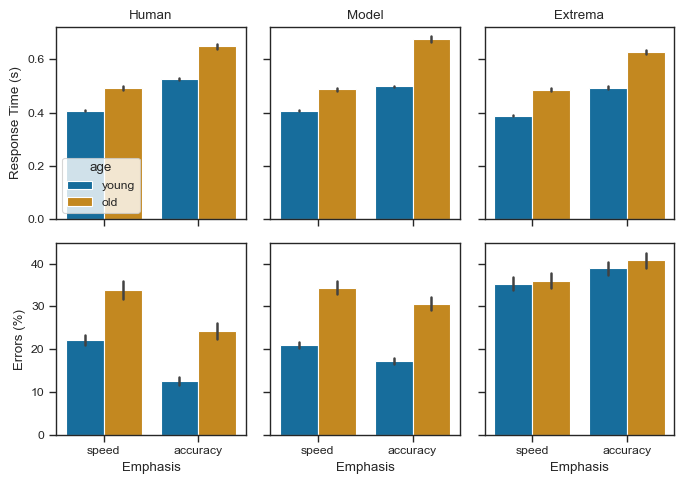

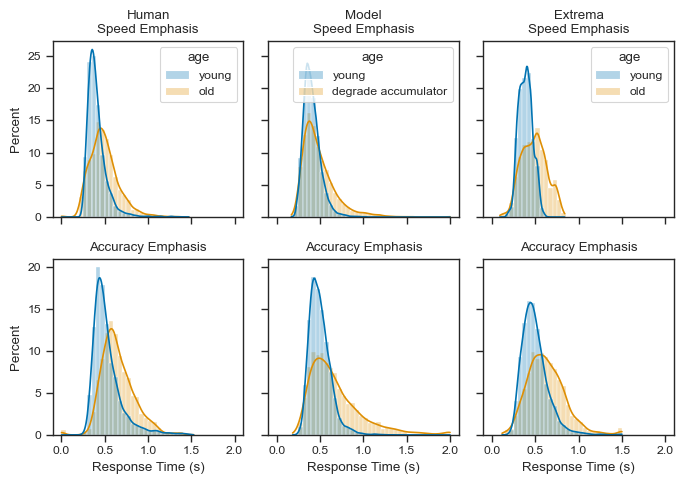

In [11]:
plot_reruns("forstmann_rerun_july8acc", "forstmann_rerun_july8per2", "forstmann_rerun_july8thr2", "forstmann2011", "forstmann_june30extrema")

In [20]:
paramfile="forstmann_optimized_params_july1"
emp = pd.read_pickle(f"data/forstmann2011.pkl").query("age=='young'")
for pid in emp['pid'].unique():
    with open(f"data/{paramfile}.json") as f:
        params = json.load(f)[pid]
    # print(pid, params['ramp'], params['threshold_speed'], params['threshold_accuracy'], params['relative'], params['sigma'], params['dt_sample'])
    string1 = "3 & \ ref{fig.forstmann_speed_accuracy} & "
    string2 = f"{pid}, speed & ${params['ramp']:.2}$ & ${params['threshold_speed']:.2}$ & ${params['relative']:.2}$ & ${params['sigma']:.2}$ & ${params['dt_sample']:.2}$ \ \ [0.5ex]"
    string3 = f"{pid}, accuracy & ${params['ramp']:.2}$ & ${params['threshold_accuracy']:.2}$ & ${params['relative']:.2}$ & ${params['sigma']:.2}$ & ${params['dt_sample']:.2}$ \ \ [0.5ex]"
    print(string1+string2)
    print(string1+string3)

3 & \ ref{fig.forstmann_speed_accuracy} & as1t, speed & $1.9$ & $0.39$ & $0.035$ & $0.37$ & $0.068$ \ \ [0.5ex]
3 & \ ref{fig.forstmann_speed_accuracy} & as1t, accuracy & $1.9$ & $0.38$ & $0.035$ & $0.37$ & $0.068$ \ \ [0.5ex]
3 & \ ref{fig.forstmann_speed_accuracy} & bd6t, speed & $1.9$ & $0.22$ & $0.47$ & $0.067$ & $0.013$ \ \ [0.5ex]
3 & \ ref{fig.forstmann_speed_accuracy} & bd6t, accuracy & $1.9$ & $0.35$ & $0.47$ & $0.067$ & $0.013$ \ \ [0.5ex]
3 & \ ref{fig.forstmann_speed_accuracy} & bl1t, speed & $1.6$ & $0.2$ & $0.36$ & $0.055$ & $0.071$ \ \ [0.5ex]
3 & \ ref{fig.forstmann_speed_accuracy} & bl1t, accuracy & $1.6$ & $0.3$ & $0.36$ & $0.055$ & $0.071$ \ \ [0.5ex]
3 & \ ref{fig.forstmann_speed_accuracy} & hsft, speed & $2.0$ & $0.32$ & $0.01$ & $0.13$ & $0.029$ \ \ [0.5ex]
3 & \ ref{fig.forstmann_speed_accuracy} & hsft, accuracy & $2.0$ & $0.4$ & $0.01$ & $0.13$ & $0.029$ \ \ [0.5ex]
3 & \ ref{fig.forstmann_speed_accuracy} & hsgt, speed & $1.9$ & $0.28$ & $0.18$ & $0.052$ & $0.08

In [28]:
paramfile="forstmann_optimized_params_july15L0"
emp = pd.read_pickle(f"data/forstmann2011.pkl").query("age=='young'")
for pid in emp['pid'].unique():
    with open(f"data/{paramfile}.json") as f:
        params = json.load(f)[pid]
    # print(pid, params['ramp'], params['threshold_speed'], params['threshold_accuracy'], params['relative'], params['sigma'], params['dt_sample'])
    string1 = "valuation & - & "
    string2 = f"{pid} & ${params['ramp']:.2}$ & ${params['threshold_speed']:.2}$ & ${params['relative']:.2}$ & ${params['sigma']:.2}$ & ${params['dt_sample']:.2}$ \ \ "
    print(string1+string2)


valuation & - & as1t & $1.3$ & $0.15$ & $0.0$ & $0.6$ & $0.03$ \ \ 
valuation & - & bd6t & $1.9$ & $0.17$ & $0.0$ & $0.43$ & $0.035$ \ \ 
valuation & - & bl1t & $1.9$ & $0.16$ & $0.0$ & $0.63$ & $0.018$ \ \ 
valuation & - & hsft & $1.4$ & $0.066$ & $0.0$ & $0.19$ & $0.023$ \ \ 
valuation & - & hsgt & $1.5$ & $0.049$ & $0.0$ & $0.27$ & $0.014$ \ \ 
valuation & - & kd6t & $1.7$ & $0.22$ & $0.0$ & $0.73$ & $0.016$ \ \ 
valuation & - & kd9t & $1.3$ & $0.079$ & $0.0$ & $0.1$ & $0.09$ \ \ 
valuation & - & kmat & $1.4$ & $0.039$ & $0.0$ & $0.11$ & $0.09$ \ \ 
valuation & - & ku4t & $1.8$ & $0.15$ & $0.0$ & $0.51$ & $0.04$ \ \ 
valuation & - & na1t & $1.6$ & $0.058$ & $0.0$ & $0.11$ & $0.028$ \ \ 
valuation & - & rmbt & $1.8$ & $0.2$ & $0.0$ & $0.62$ & $0.035$ \ \ 
valuation & - & rt2t & $1.7$ & $0.073$ & $0.0$ & $0.2$ & $0.033$ \ \ 
valuation & - & rt3t & $1.5$ & $0.23$ & $0.0$ & $0.63$ & $0.043$ \ \ 
valuation & - & rt5t & $1.4$ & $0.24$ & $0.0$ & $0.78$ & $0.096$ \ \ 
valuation & - & scat &

## Errors (full model vs reduced model)

In [14]:
def get_kde_loss(simulated, empirical):
    total_loss = 0
    eval_points = np.linspace(0, 1.5, 1000)
    rts_sim = simulated['RT'].to_numpy()
    rts_emp = empirical['RT'].to_numpy()
    # print(rts_sim)
    # print(rts_emp)
    # check for zero variance and assign error accordingly
    if len(simulated['RT'].unique())==1:
        mean_emp = np.mean(rts_emp)
        mean_sim = np.mean(rts_sim)
        kde_loss = np.abs(mean_emp - mean_sim)
    else:     
        kde_emp = gaussian_kde(rts_emp, bw_method='scott')
        kde_sim = gaussian_kde(rts_sim, bw_method='scott')
        estimate_emp = kde_emp.evaluate(eval_points)
        estimate_sim = kde_sim.evaluate(eval_points)
        estimate_emp = estimate_emp / np.sum(estimate_emp)
        estimate_sim = estimate_sim / np.sum(estimate_sim)
        kde_loss = 1000*np.sqrt(np.mean(np.square(estimate_emp - estimate_sim)))
    total_loss += kde_loss
    return total_loss

def get_acc_loss(simulated, empirical):
    acc_sim = simulated['error'].mean()
    acc_emp = empirical['error'].mean()
    return np.abs(acc_sim - acc_emp)

In [15]:
def print_errors_forstmann(simfile, empfile, extrfile, by_emphasis=True):

    sim = pd.read_pickle(f"data/{simfile}.pkl").query("age=='young'")
    emp = pd.read_pickle(f"data/{empfile}.pkl").query("age=='young'")
    extr = pd.read_pickle(f"data/{extrfile}.pkl").query("age=='young'")
    combined = pd.concat([sim, emp, extr])
    order = ['speed', 'accuracy']
    combined = combined.query("emphasis in @order")

    if not by_emphasis:
        sim_kde_losses = []
        extr_kde_losses = []
        sim_acc_losses = []
        extr_acc_losses = []
    for emphasis in ['speed', 'accuracy']:
        if by_emphasis:
            sim_kde_losses = []
            extr_kde_losses = []
            sim_acc_losses = []
            extr_acc_losses = []
        for pid in emp['pid'].unique():
            sub_sim = sim.query("pid==@pid & emphasis==@emphasis")
            sub_extr = extr.query("pid==@pid & emphasis==@emphasis")
            sub_emp = emp.query("pid==@pid & emphasis==@emphasis")
            # print(sub_sim)
            # print(sub_emp)
            # print(sub_extr)
            # raise
            sim_kde_losses.append(get_kde_loss(sub_sim, sub_emp))
            extr_kde_losses.append(get_kde_loss(sub_extr, sub_emp))
            sim_acc_losses.append(get_acc_loss(sub_sim, sub_emp))
            extr_acc_losses.append(get_acc_loss(sub_extr, sub_emp))
        if by_emphasis:
            print(f"{emphasis}, sim kde loss, {np.mean(sim_kde_losses):.3f}")
            print(f"{emphasis}, sim acc loss, {np.mean(sim_acc_losses):.3f}")
            print(f"{emphasis}, extr kde loss, {np.mean(extr_kde_losses):.3f}")
            print(f"{emphasis}, extr acc loss, {np.mean(extr_acc_losses):.3f}")
    
    if not by_emphasis:
        print(f"sim kde loss, {np.mean(sim_kde_losses):.3f}")
        print(f"sim acc loss, {np.mean(sim_acc_losses):.3f}")
        print(f"extr kde loss, {np.mean(extr_kde_losses):.3f}")
        print(f"extr acc loss, {np.mean(extr_acc_losses):.3f}")

In [49]:
print_errors_forstmann("forstmann_rerun_july8acc", "forstmann2011", "forstmann_june30extrema", by_emphasis=False)

sim kde loss, 0.500
sim acc loss, 4.864
extr kde loss, 0.876
extr acc loss, 19.905


In [16]:
print_errors_forstmann("forstmann_rerun_july8acc", "forstmann2011", "forstmann_rerun_july15L0", by_emphasis=True)

speed, sim kde loss, 0.497
speed, sim acc loss, 3.238
speed, extr kde loss, 0.534
speed, extr acc loss, 5.030
accuracy, sim kde loss, 0.503
accuracy, sim acc loss, 6.490
accuracy, extr kde loss, 0.588
accuracy, extr acc loss, 12.250


### ETC

In [ ]:
trials = 200
tmax = 1.5
ages = ['young', 'old']
emphases = ['speed', 'accuracy']
label = "june30extrema"

emp = pd.read_pickle(f"data/forstmann2011.pkl")
for age in ages:
    # age_label = 'young' if age=='young' else 'increase threshold'
    age_label = age
    for pid in emp.query("age==@age")['pid'].unique():
        if age=='young':
            with open(f"data/forstmann_optimized_params_young_june30extrema.json") as f:
                params = json.load(f)[pid]
        if age=='old':
            with open(f"data/forstmann_optimized_params_old_june30extrema.json") as f:
                params = json.load(f)[pid]
        for emphasis in emphases:
            print(pid, age, emphasis)
            if emphasis=='speed': threshold = params['threshold_speed']
            if emphasis=='accuracy': threshold = params['threshold_accuracy']
            simulate_extrema(
                pid=pid,
                trials=trials,
                emphasis=emphasis,
                age=age_label,
                threshold=threshold,
                coherence=params['coherence'],
                nd_mean=params['nd_mean'],
                nd_sigma=params['nd_sigma'],
                sigma=params['sigma'],
                dt_sample=params['dt_sample'],
                tmax=tmax,
                name=f"forstmann_extrema_{pid}_{age}_{emphasis}_{label}")

dfs = []
for age in ages:
    for pid in emp.query("age==@age")['pid'].unique():
        for emphasis in emphases:
            dfs.append(pd.read_pickle(f"data/forstmann_extrema_{pid}_{age}_{emphasis}_{label}.pkl"))
extrema = pd.concat(dfs, ignore_index=True)
extrema.to_pickle(f"data/forstmann_{label}.pkl")

In [43]:
def plot_SAT(simfile, empfile, extrfile):
    sim = pd.read_pickle(f"data/{simfile}.pkl")
    emp = pd.read_pickle(f"data/{empfile}.pkl")
    extr = pd.read_pickle(f"data/{extrfile}.pkl")
    combined = pd.concat([sim, emp, extr])
    ages = ['young', 'old']
    emphases = ['speed', 'accuracy']
    combined = combined.query("emphasis in @emphases")
    palette2 = palette[:3]

    dfs = []
    columns = ['pid', 'type', 'emphasis', 'age', 'mean_error', 'mean_RT']
    for pid in combined['pid'].unique():
        for model_type in ['human', 'model', 'extrema']:
            for age in ['young', 'old']:
                for emphasis in ['speed', 'accuracy']:
                    data = combined.query("pid==@pid & type==@model_type & age==@age & emphasis==@emphasis")
                    dfs.append(pd.DataFrame([[pid, model_type, emphasis, age, data['error'].mean(), data['RT'].mean()]], columns=columns))
    df_sat = pd.concat(dfs, ignore_index=True)
    
    fig = sns.FacetGrid(df_sat, col='type', hue='emphasis', row="age", row_order=ages, legend_out=False,
                        col_order=['human', 'model', 'extrema'], hue_order=emphases, palette=palette, height=2, aspect=2)
    fig.map_dataframe(sns.scatterplot, x="mean_RT", y='mean_error')
    fig.set_xlabels("Mean Response Time (s)")
    fig.set_ylabels("Mean Error Rate (%)")
    fig.add_legend()
    plt.tight_layout()
    fig.savefig(f"plots/forstmann_SAT.svg")
    fig.savefig(f"plots/forstmann_SAT.png", dpi=600)

In [44]:
def plot_single(simfile):
    sim = pd.read_pickle(f"data/{simfile}.pkl")
    emp = pd.read_pickle(f"data/forstmann2011.pkl").query("pid=='bd6t'")
    combined = pd.concat([sim, emp])
    order = ['speed', 'accuracy']
    combined = combined.query("emphasis in @order & age=='young'")
    
    bins = np.arange(0, 1.1, 0.05)
    fig = sns.FacetGrid(combined, col='age', hue='type', row="emphasis", row_order=order, legend_out=False,
                        hue_order=['human', 'model'], palette=palette, height=2, aspect=2)
    fig.map_dataframe(sns.histplot, x="RT", stat='percent', kde=True, bins=bins, common_norm=False, alpha=0.3,
                     kde_kws={'bw_adjust': 1, 'cut': 2, 'clip': [bins[0], bins[-1]]})
    fig.set_xlabels("Response Time (s)")
    fig.add_legend()
    plt.tight_layout()
    plt.show()
    
    bins = np.arange(0, 1.1, 0.05)
    fig = sns.FacetGrid(combined, hue='emphasis', row="type", hue_order=order, legend_out=False,
                        row_order=['human', 'model'], palette=palette, height=2, aspect=2)
    fig.map_dataframe(sns.histplot, x="RT", stat='percent', kde=True, bins=bins, common_norm=False, alpha=0.3,
                     kde_kws={'bw_adjust': 1, 'cut': 2, 'clip': [bins[0], bins[-1]]})
    fig.set_xlabels("Response Time (s)")
    fig.add_legend()
    plt.tight_layout()
    plt.show()
    
    fig = sns.FacetGrid(combined, col='type', hue='age', col_order=['human', 'model'],
                        legend_out=False, palette=palette, height=2, aspect=2)
    fig.map_dataframe(sns.barplot, x="emphasis", y='error', order=order)
    # fig.set_xlabels("Response Time (s)")
    fig.add_legend()
    plt.tight_layout()
    plt.show()

In [40]:
# plot_SAT("forstmann_test", "forstmann2011", "forstmann_june30extrema")

In [39]:
# plot_individuals("forstmann_july1_degrade_acc", "forstmann2011", "forstmann_june30extrema", bins=np.arange(0.0, 1.6, 0.05))